In [1]:

!tar -xzvf "/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/dataset_purchase.tgz" -C "/content/"

!mv "/content/dataset_purchase" "/content/dataset_purchase.csv"

dataset_purchase


In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import numpy as np
import random
import torch
import os
import pandas as pd
import numpy as np

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


class TargetModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TargetModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.output(x)
        return x


def create_df_with_membership_status_using_model_outputs(model, member_df, non_member_df):

    ''' create a dataframe from the outputs of a model
    and add a column refering to the membership status of each record '''

    member_tensor = torch.tensor(member_df.values, dtype=torch.float32)
    non_member_tensor = torch.tensor(non_member_df.values, dtype=torch.float32)

    # use the provided model to generate outputs
    model.eval()
    member_outputs =  F.softmax(model(member_tensor), dim=1)
    non_member_outputs = F.softmax(model(non_member_tensor), dim=1)

    in_df = pd.DataFrame(member_outputs.detach().numpy())
    in_df['membership'] = True

    out_df = pd.DataFrame(non_member_outputs.detach().numpy())
    out_df['membership'] = False

    concatenated_df = pd.concat([in_df, out_df])

    return concatenated_df


def get_mia_stats(member_df, non_member_df, atk_model, tgt_model):
    X_member_df = member_df.copy()
    X_non_member_df = non_member_df.sample(n=len(X_member_df), replace=False).drop(columns=non_member_df.columns[0], axis=1)

    dataset_from_target_model_outputs = create_df_with_membership_status_using_model_outputs(tgt_model, X_member_df, X_non_member_df)

    X_attack = dataset_from_target_model_outputs.drop(columns=['membership'])
    y_attack = dataset_from_target_model_outputs['membership']

    y_attack_pred = atk_model.predict(X_attack)

    accuracy = atk_model.score(X_attack, y_attack)

    f1 = f1_score(y_attack, y_attack_pred)

    # print(f"Test F1 Score: {f1:.4f}")
    # print(f"Test Accuracy: {accuracy:.4f}")

    return f1, accuracy

df = pd.read_csv('/content/dataset_purchase.csv')

set_seed(150)
target_dataset_head_rows = 50_000
train_df, test_df = train_test_split(df.head(target_dataset_head_rows), test_size=0.2)
retain_df, forget_df = train_test_split(train_df, test_size=0.1)



Random seed set as 150


In [58]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
import joblib

def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total


def unlearn_target_nn(model, forget_loader, val_loader, retain_loader, tst_real_loader, criterion, optimizer, epochs, max_val_loss=0.01 ):

    best_val_loss = float('inf')
    patience_counter = 0
    test_acc = []
    forget_acc = []
    retain_acc = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        model.train()
        running_loss = 0.0

        for batch_idx, (x_forget, y_forget) in enumerate(forget_loader):
            optimizer.zero_grad()
            outputs_forget = model(x_forget)
            loss_forget = -criterion(outputs_forget, y_forget)
            loss_forget.backward()
            optimizer.step()

            running_loss += loss_forget.item()

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
            val_loss /= len(val_loader)

            if val_loss > max_val_loss:
                print(f"Early stopping because validation loss exceeded the maximum allowed threshold: {max_val_loss:.4f}")
                return forget_acc, test_acc, retain_acc

            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(forget_loader)}] - Forget Loss: {loss_forget.item():.4f}")

                # Calculate accuracy for each loader
                forget_accuracy = calculate_accuracy(forget_loader, model)
                val_accuracy = calculate_accuracy(val_loader, model)
                retain_accuracy = calculate_accuracy(retain_loader, model)
                test_accuracy = calculate_accuracy(tst_real_loader, model)

                forget_acc.append(forget_accuracy)
                retain_acc.append(retain_accuracy)
                test_acc.append(test_accuracy)

                print(f"Forget Accuracy: {forget_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Retain Accuracy: {retain_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return forget_acc, test_acc, retain_acc



set_seed(42)

# load the trained target model
FOLDER_NAME = 'Unlearning/full_data_target_model_seed_150'
FOLDER_PATH = f'/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/{FOLDER_NAME}'
target_model = torch.jit.load(f'{FOLDER_PATH}/full_data_target_model_seed_150.pt')

# target_dataset_head_rows = 50_000
# train_df, test_df = train_test_split(df.head(target_dataset_head_rows), test_size=0.2)
# retain_df, forget_df = train_test_split(train_df, test_size=0.1)

X_test_real = test_df.drop(columns=test_df.columns[0], axis=1)
y_test_real = test_df.iloc[:, 0] - 1

print(retain_df.shape, forget_df.shape)

# split the retain into train and test for the training process
target_model_df = retain_df.copy()
X = target_model_df.drop(columns=target_model_df.columns[0], axis=1)
y = target_model_df.iloc[:, 0] - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape)

# prepare forget data to feed them into unlearning
X_forget = forget_df.drop(columns=forget_df.columns[0], axis=1)
y_forget = forget_df.iloc[:, 0] - 1

# for doing the mia
folder_name = f'Unlearning'
folder_path = f"/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/{folder_name}"
attack_model = joblib.load(folder_path + "/attack_model_pre_trained.joblib")
never_seen_before_data_df = df.iloc[90_000:]

X_retain = retain_df.drop(columns=retain_df.columns[0], axis=1)
y_retain = retain_df.iloc[:, 0] - 1

if __name__ == "__main__":

    # Set the parameters
    n_features = X_train.shape[1]
    n_classes = len(set(y_train))

    # Convert data to PyTorch tensors
    X_forget_tensor = torch.tensor(X_forget.values, dtype=torch.float32)
    y_forget_tensor = torch.tensor(y_forget.values, dtype=torch.long)

    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    X_retain_tensor = torch.tensor(X_retain.values, dtype=torch.float32)
    y_retain_tensor = torch.tensor(y_retain.values, dtype=torch.long)

    X_test_real_tensor = torch.tensor(X_test_real.values, dtype=torch.float32)
    y_test_real_tensor = torch.tensor(y_test_real.values, dtype=torch.long)

    hidden_size = 128
    learning_rate = 0.003
    epochs = 50
    batch_size = 32

    forget_data = TensorDataset(X_forget_tensor, y_forget_tensor)
    forget_loader = DataLoader(forget_data, batch_size=batch_size, shuffle=True)

    test_data = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    retain_data = TensorDataset(X_retain_tensor, y_retain_tensor)
    retain_loader = DataLoader(retain_data, batch_size=batch_size, shuffle=True)

    test_real_data = TensorDataset(X_test_real_tensor, y_test_real_tensor)
    test_real_loader = DataLoader(test_real_data, batch_size=batch_size, shuffle=True)

    print(f"Forget Data Size: {len(forget_data)}")
    print(f"Test Data Size: {len(test_data)}")
    print(f"Retain Data Size: {len(retain_data)}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(target_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-7)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    forget_acc, test_acc, retain_acc = unlearn_target_nn(target_model, forget_loader, test_loader, retain_loader, test_real_loader,  criterion, optimizer, epochs, max_val_loss=0.4)


Random seed set as 42
(36000, 601) (4000, 601)
(28800, 600) (7200, 600)
Forget Data Size: 4000
Test Data Size: 7200
Retain Data Size: 36000


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Batch [1/125] - Forget Loss: -0.0039
Forget Accuracy: 1.0000, Validation Accuracy: 1.0000, Retain Accuracy: 1.0000, Test Accuracy: 0.8180
Epoch [1/50], Batch [11/125] - Forget Loss: -0.0053
Forget Accuracy: 1.0000, Validation Accuracy: 1.0000, Retain Accuracy: 1.0000, Test Accuracy: 0.8180
Epoch [1/50], Batch [21/125] - Forget Loss: -0.0036
Forget Accuracy: 1.0000, Validation Accuracy: 1.0000, Retain Accuracy: 1.0000, Test Accuracy: 0.8182
Epoch [1/50], Batch [31/125] - Forget Loss: -0.0039
Forget Accuracy: 1.0000, Validation Accuracy: 1.0000, Retain Accuracy: 1.0000, Test Accuracy: 0.8182
Epoch [1/50], Batch [41/125] - Forget Loss: -0.0045
Forget Accuracy: 1.0000, Validation Accuracy: 1.0000, Retain Accuracy: 1.0000, Test Accuracy: 0.8183
Epoch [1/50], Batch [51/125] - Forget Loss: -0.0026
Forget Accuracy: 1.0000, Validation Accuracy: 1.0000, Retain Accuracy: 1.0000, Test Accuracy: 0.8183
Epoch [1/50], Batch [61/125] - Forget Loss: -0.0043
Forget Accuracy: 1.0000, Valida

In [59]:
print(len(forget_acc), len(test_acc), len(retain_acc))

54 54 54


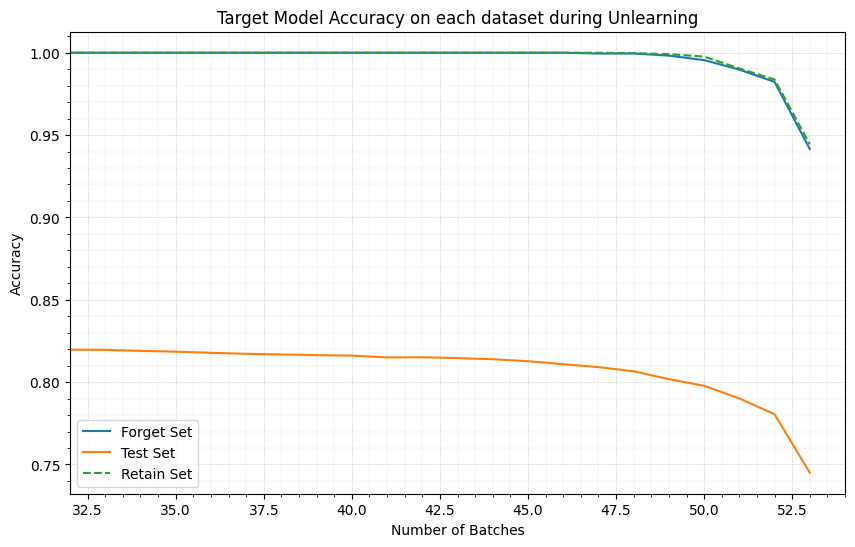

In [60]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Assuming forget_acc, test_acc, and retain_acc are lists of accuracies

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(forget_acc, label='Forget Set', linestyle='-')
ax.plot(test_acc, label='Test Set', linestyle='-')
ax.plot(retain_acc, label='Retain Set', linestyle='--')

ax.grid(True, linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth=0.25)

# show more values on the y axis
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.yaxis.set_major_locator(MaxNLocator(nbins=20))

# Set x-axis to focus on the later half
# mid_point = len(forget_acc) // 2 + 5
# ax.set_xlim(mid_point, len(forget_acc))

ax.set_xlabel('Number of Batches')
ax.set_ylabel('Accuracy')
ax.set_title('Target Model Accuracy on each dataset during Unlearning')

ax.legend(loc='lower left')
plt.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Define x values

# Define y values for each line
y1 = forget_acc
y2 = test_acc
y3 = retain_acc

# Create a Figure object
fig = go.Figure()

# Add traces for each line
fig.add_trace(go.Scatter( y=y1, mode='lines', name='forget set', line=dict(color='red')))
fig.add_trace(go.Scatter( y=y2, mode='lines', name='test set', line=dict(color='green')))
fig.add_trace(go.Scatter( y=y3, mode='lines', name='retain set', line=dict(color='blue')))


# Update layout to add title and customize its appearance
fig.update_layout(
    title="Target Model Accuracy on each dataset during Unlearning",
    title_font=dict(size=24, color='black'),  # Custom font size and color
    title_x=0.5,  # Center the title horizontally
    title_y=0.95,  # Position the title near the top vertically
    xaxis_title="Batches Unlearned",
    yaxis_title="Accuracy",
    legend_title="Data Sets",

)
# Show the figure
fig.show()
